<a href="https://colab.research.google.com/github/norflin321/ml/blob/main/SDXL_sketch2img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -U git+https://github.com/huggingface/diffusers.git controlnet_aux==0.0.7 > install_logs.txt
%pip install transformers accelerate safetensors mediapipe invisible_watermark > install_logs.txt

from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL, StableDiffusionInstructPix2PixPipeline, StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image, make_image_grid
from controlnet_aux.pidi import PidiNetDetector
import torch
from matplotlib import pyplot as plt
import datetime

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-r1yhxedm


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
# load euler_a scheduler
euler_a = EulerAncestralDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pidinet = PidiNetDetector.from_pretrained("lllyasviel/Annotators").to("cuda")

# load adapter
adapter = T2IAdapter.from_pretrained("TencentARC/t2i-adapter-sketch-sdxl-1.0", torch_dtype=torch.float16, varient="fp16").to("cuda")

# load SDXL model
pipe = StableDiffusionXLAdapterPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", vae=vae, adapter=adapter, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16").to("cuda")

# load finetuned weights
pipe.load_lora_weights("./finetuned", weight_name="pytorch_lora_weights.safetensors")

# refiner makes result image better, but doesn't work in free google colab because not enough VRAM
# refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0", torch_dtype=torch.float16)
# refiner.to("cuda")
# generator = torch.Generator("cuda").manual_seed(42)

# prepare sketch image
# url = "https://i.imgur.com/HE1TYkx.png"
url = "https://i.imgur.com/m92Alz2.png"
image = load_image(url)
image = pidinet(image, detect_resolution=1024, image_resolution=1024, apply_filter=True)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/controlnet_aux/pidi/model.py:334: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  buffer = torch.cuda.FloatTensor(shape[0], shape[1], 5 * 5).fill_(0)


  0%|          | 0/50 [00:00<?, ?it/s]

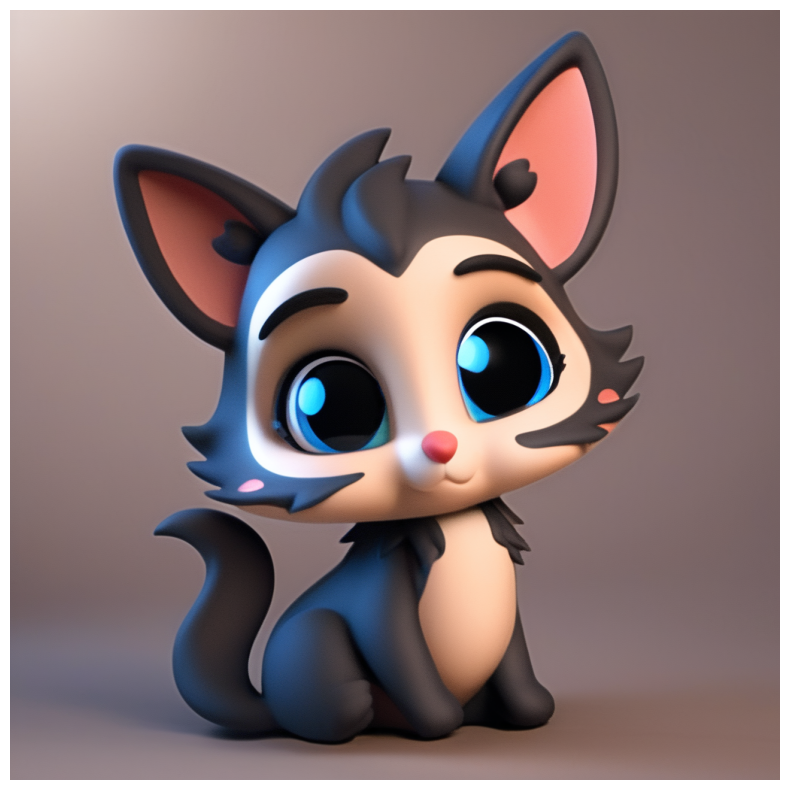

seed: 94430


In [6]:
# HYPERPARAMS
prompt = "a magic creature in style of sks, 3D, blender, perfect, 4k graphics, highly detailed, cute, pretty"
negative_prompt = "extra digit, fewer digits, cropped, worst quality, low quality, glitch, deformed, mutated, ugly, disfigured"
steps = 50
guidance = 8
adapter_conditioning_scale = 0.9
seed = None # 36242

# generate
current_seed = seed or torch.randint(0, int(1e5), size=(1, 1))[0].item()
generator = torch.Generator().manual_seed(int(current_seed))
img = pipe(prompt=prompt, negative_prompt=negative_prompt, image=image, num_inference_steps=steps, adapter_conditioning_scale=adapter_conditioning_scale, guidance_scale=guidance, generator=generator).images[0]
# img = refiner(prompt=prompt, generator=generator, image=img).images[0]
time_now = datetime.datetime.now().strftime("%y.%m.%d_%H:%M:%S")
img.save(f"./{time_now}_{current_seed}.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()
print("seed:", current_seed)